Loading train/test splits...
Using pos_weight: 5.5864
Training model with hidden_dim=32, dropout_rate=0.2
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average Validation Loss for hidden_dim=32, dropout_rate=0.2: 1.1308
Training model with hidden_dim=32, dropout_rate=0.3
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average Validation Loss for hidden_dim=32, dropout_rate=0.3: 1.1357
Training model with hidden_dim=32, dropout_rate=0.5
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average Validation Loss for hidden_dim=32, dropout_rate=0.5: 1.1427
Training model with hidden_dim=64, dropout_rate=0.2
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Average Validation Loss for hidden_dim=64, dropout_rate=0.2: 1.0850
Training model with hidden_dim=64, dropout_rate=0.3
Training fold 1...
Training fold 2

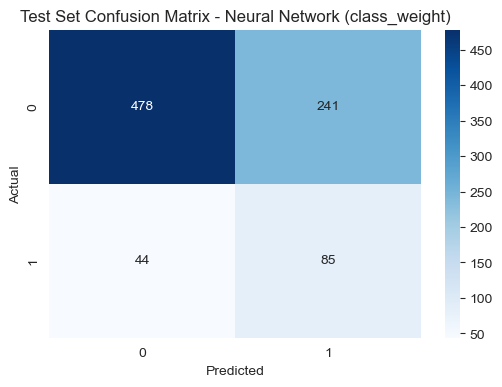

Model saved to ../models/simple_nn_class_weight.pth


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 2. Define Neural Network with Dropout Regularization
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x  # Note: No sigmoid here; we use BCEWithLogitsLoss

# 3. Compute class weights
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32)  # For BCEWithLogitsLoss
print(f"Using pos_weight: {pos_weight.item():.4f}")

# 4. Hyperparameter Grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5]
}

# 5. Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_val_loss = float('inf')
best_hyperparameters = {}

# 6. Iterate over parameter grid
for hidden_dim in param_grid['hidden_dim']:
    for dropout_rate in param_grid['dropout_rate']:
        print(f"Training model with hidden_dim={hidden_dim}, dropout_rate={dropout_rate}")
        val_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
            print(f"Training fold {fold + 1}...")

            X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
            y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

            model = SimpleNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            for epoch in range(20):  # 20 epochs
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_fold)
                loss = criterion(outputs, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs, y_val_fold)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        print(f"Average Validation Loss for hidden_dim={hidden_dim}, dropout_rate={dropout_rate}: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_hyperparameters = {'hidden_dim': hidden_dim, 'dropout_rate': dropout_rate}

print(f"\nBest Hyperparameters: {best_hyperparameters}")

# 7. Train the best model on the full training set with the best hyperparameters
best_model = SimpleNN(input_dim=X_train.shape[1], hidden_dim=best_hyperparameters['hidden_dim'], dropout_rate=best_hyperparameters['dropout_rate'])
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(20):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 8. Evaluate on test set
best_model.eval()
with torch.no_grad():
    test_logits = best_model(X_test_tensor)
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs >= 0.5).int()

test_accuracy = accuracy_score(y_test, test_preds.numpy())
print("Test Set Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, test_preds.numpy()))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, test_preds.numpy())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix - Neural Network (class_weight)")
plt.show()

# 10. Save model
os.makedirs("../models", exist_ok=True)
torch.save(best_model.state_dict(), "../models/simple_nn_class_weight.pth")
print("Model saved to ../models/simple_nn_class_weight.pth")
